In [1]:
import lsst.daf.persistence as dafPersist


In [5]:
import scipy

In [2]:

DATADIR="/renoir_data_02/jpreyes/lsst_data/CFHTLS_master/"
butler = dafPersist.Butler(DATADIR+"/output") 

In [9]:
dataRef = {"visit":850586, "ccd":14, "filter":'r'}
calexp = butler.get("calexp", dataId=dataRef)
dr =butler.dataRef("calexp", dataId=dataRef)

In [11]:
from lsst.ip.diffim import GetCoaddAsTemplateTask, GetCalexpAsTemplateTask
gtTask = GetCalexpAsTemplateTask()
results = gtTask.run( calexp, dr, templateIdList=
                      [ {'visit':986881, 'filter':'r', 'ccd':14}   ])

.....
{'filter': 'r', 'ccd': 14, 'visit': 986881}
.....


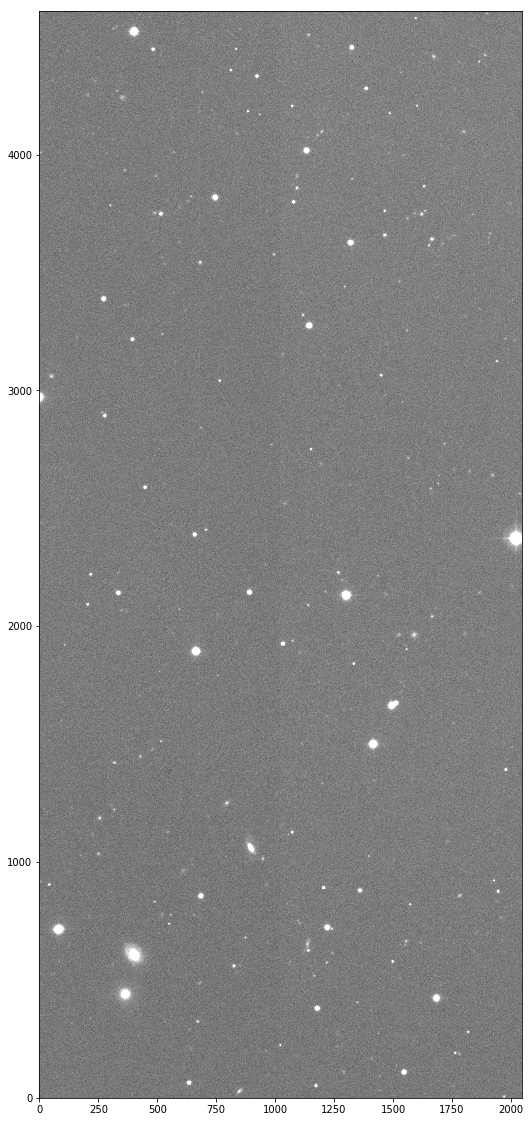

In [40]:
%matplotlib inline
import matplotlib.pyplot as plt

template = results.exposure

plt.figure(figsize =(40,20))
img_arr, mask_arr, var_arr = template.getMaskedImage().getArrays()
w,h = template.getWidth(), template.getHeight()  
plt.imshow(img_arr, origin='lower', vmin=img_arr.mean()-img_arr.std(), vmax=img_arr.mean()+img_arr.std(), cmap='gray', extent=(0,w-1, 0, h-1), interpolation='none')


In [41]:
import lsst.pex.config as pexConfig
from lsst.ip.diffim.psfMatch import PsfMatchTask, PsfMatchConfigDF, PsfMatchConfigAL
from lsst.meas.algorithms import SourceDetectionTask, getBackground
from lsst.meas.base import SingleFrameMeasurementTask
import lsst.afw.math as afwMath

class ImagePsfMatchConfig(pexConfig.Config):
    """!Configuration for image-to-image Psf matching"""
    kernel = pexConfig.ConfigChoiceField(
        doc="kernel type",
        typemap=dict(
            AL=PsfMatchConfigAL,
            DF=PsfMatchConfigDF
        ),
        default="AL",
    )
    selectDetection = pexConfig.ConfigurableField(
        target=SourceDetectionTask,
        doc="Initial detections used to feed stars to kernel fitting",
    )
    selectMeasurement = pexConfig.ConfigurableField(
        target=SingleFrameMeasurementTask,
        doc="Initial measurements used to feed stars to kernel fitting",
    )

    def setDefaults(self):
        # High sigma detections only
        self.selectDetection.reEstimateBackground = False
        self.selectDetection.thresholdValue = 10.0

        # Minimal set of measurments for star selection
        self.selectMeasurement.doApplyApCorr = "no"
        self.selectMeasurement.algorithms.names.clear()
        self.selectMeasurement.algorithms.names = ('base_SdssCentroid', 'base_PsfFlux', 'base_PixelFlags',
                                                   'base_SdssShape', 'base_GaussianFlux', 'base_SkyCoord')
        self.selectMeasurement.slots.modelFlux = None
        self.selectMeasurement.slots.apFlux = None
        self.selectMeasurement.slots.calibFlux = None
        
config = ImagePsfMatchConfig()
kConfig = config.kernel.active
warper = afwMath.Warper.fromConfig(kConfig.warpingConfig)
templateExposure = warper.warpExposure(calexp.getWcs(), results.exposure, destBBox=calexp.getBBox())

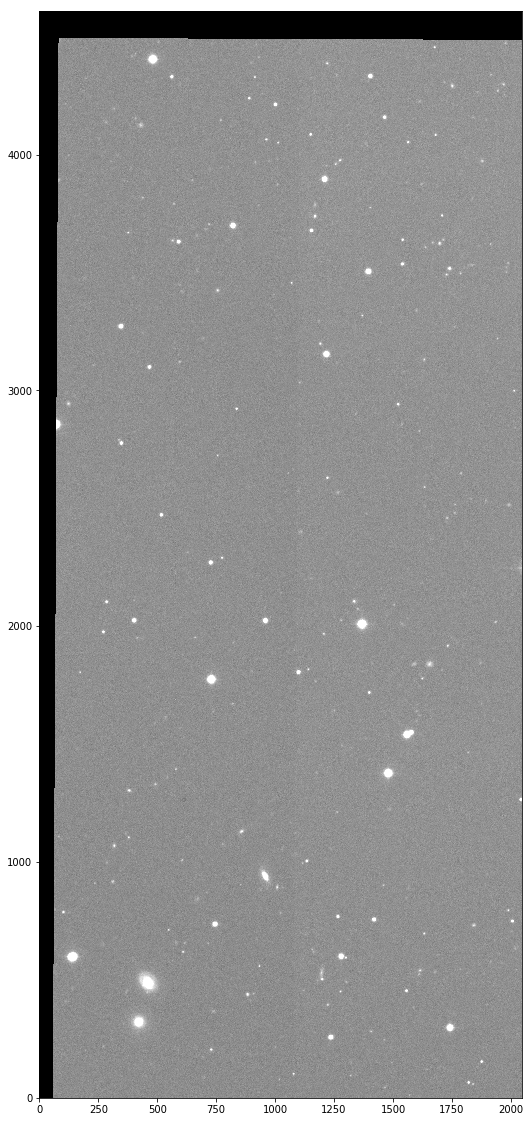

In [46]:
plt.figure(figsize =(40,20))
img_arr, mask_arr, var_arr = templateExposure.getMaskedImage().getArrays()
img_arr = np.nan_to_num(img_arr)
w,h = template.getWidth(), template.getHeight()  
plt.imshow(img_arr, origin='lower', vmin=img_arr.mean()-img_arr.std(), vmax=img_arr.mean()+img_arr.std(), cmap='gray', extent=(0,w-1, 0, h-1), interpolation='none')


In [45]:
import numpy as np
np.nan_to_num(img_arr).mean()

1115.8346

In [52]:
import lsst.afw.geom as afwGeom

ctr = afwGeom.Box2D(calexp.getBBox()).getCenter()
psf = calexp.getPsf()



In [79]:
kernel = psf.getLocalKernel()

[[  1.39792737e-04   9.82039447e-05  -1.16558000e-04  -2.40445948e-04
    1.93679058e-04  -1.89910374e-05  -2.45500776e-04  -1.04722240e-05
   -2.30496121e-04  -2.55350667e-04  -1.38446796e-04  -1.86994039e-04
   -8.88311560e-05   5.74383290e-05  -1.34318012e-04   3.47188452e-04
    3.91466820e-04   1.47195281e-04   2.46756141e-04   3.42247534e-05
   -7.63145899e-05   1.05507009e-04  -1.02992746e-04  -1.26296573e-04
   -7.41203096e-05  -2.25132162e-04  -4.18230611e-05]
 [ -3.19881866e-04  -2.39491928e-05   2.47718832e-05  -2.85212468e-04
    1.88103864e-04  -3.64512328e-04  -1.04843313e-04   2.23629771e-04
   -1.10416301e-05   5.26534362e-05  -1.01499714e-04  -1.86870733e-04
    1.33896243e-04   3.94685194e-05  -1.76311892e-04  -1.19960702e-04
   -1.07127052e-04   2.57759381e-04  -1.79755050e-05  -3.91938152e-05
   -2.34420957e-06   9.49296651e-06   8.71438883e-05  -3.05301326e-05
   -3.19172440e-04  -3.19959396e-04   1.41843432e-04]
 [  1.05059563e-04   3.98087446e-04   3.05709609e-04

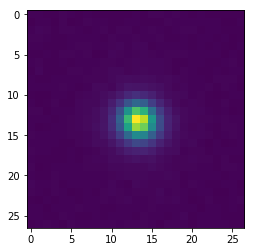

In [87]:
im = psf.computeImage()
arr = im.getArray()
plt.imshow(arr)


In [96]:
import scipy.signal as sciSig
result = sciSig.correlate2d(img_arr, arr)

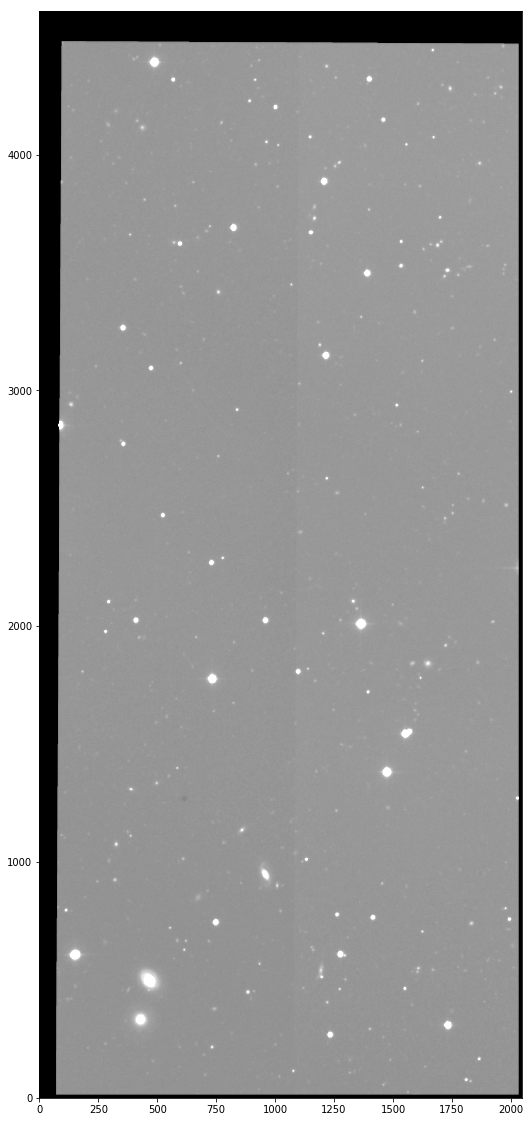

In [100]:
plt.figure(figsize =(40,20))
result = np.flipud(result)
plt.imshow(result,  vmin=result.mean()-result.std(), vmax=result.mean()+result.std(), cmap='gray', extent=(0,w-1, 0, h-1), interpolation='none')